In [2]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_23440/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

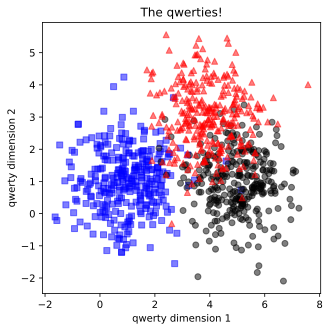

In [3]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 16
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset,  batch_size=test_batch_size)

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {train_batch_size} samples')

There are 50 batches, each with 16 samples


# Model

In [5]:
def create_the_qwety_net(optimizer_algo, learning_rate):
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer_func = getattr(torch.optim, optimizer_algo)
    optimizer      = optimizer_func(net.parameters(), lr=learning_rate)


    return net, loss_func, optimizer

# # Test the model with optimizer type as input

# # Try 'SGD', 'RMSprop', and 'Adam'
# optim = create_the_qwety_net('RMSprop')[2]
# optim

# Training

In [6]:
num_epochs = 50

def train_the_model(optimizer_type, learning_rate):
  
  net, loss_func, optimizer = create_the_qwety_net(optimizer_type, learning_rate)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      y_hat = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses, net

# Experiment

In [7]:
# Variables to loop over
learning_rates  = np.logspace(start=np.log10(0.0001), stop=np.log10(0.1), num=20)
optimizer_types = ['SGD', 'RMSprop', 'Adam']

# Initialize performance matrix
final_performance = np.zeros(shape=(len(learning_rates), len(optimizer_types)))

# Now for the experiment!
for idx_optimizer, optimizer_i in enumerate(optimizer_types):
  for idx_l_rate, l_rate_i in enumerate(learning_rates):
    train_acc, test_acc, losses, net = train_the_model(optimizer_type=optimizer_i, learning_rate=l_rate_i)
    final_performance[idx_l_rate, idx_optimizer] = np.mean(test_acc[-10:])

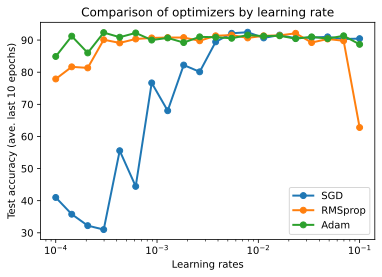

In [8]:
# Plot the results! 
plt.plot(learning_rates, final_performance, 'o-', linewidth=2)
plt.legend(optimizer_types)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

# Optional explorations
1) Which optimizer is best for quick learning? Re-run the code but average accuracy in the FIRST 10 training epochs 
   instead of the FINAL 10 training epochs.

2) Similar question but for batch size. Try using batch sizes ranging from 2**4 (16) to 2**7 (128).